# INDENG 142 Final Project
##SF Parking Time and Availability Prediction
###Team Members: Aryan Shah, Jessica Lee, Kaitlyn Zhang, Mahum Malik, Rohan Godara, Shayan Khoygani



In [ ]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# Suppress all warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')

Mounted at /content/drive


#Data Pre-Processing

In [ ]:
#Data pulled from sfdata and saved on google drive
parking = pd.read_csv('/content/drive/MyDrive/INDENG 142 Final Project/SFMTA_Parking_Meter_Detailed_Revenue_Transactions.csv')
parking.head()

,TRANSMISSION_DATETIME,POST_ID,STREET_BLOCK,PAYMENT_TYPE,SESSION_START_DT,SESSION_END_DT,METER_EVENT_TYPE,GROSS_PAID_AMT
0,225257083_4_03012022190806,830-04130,EMBARCADERO NORTH 400,CREDIT CARD,2022/03/01 07:08:06 PM,2022/03/01 09:25:15 PM,NS,4.00
1,225257084_4_03012022190901,462-17120,HAIGHT ST 1700,CASH,2022/03/01 07:09:01 PM,2022/03/01 07:09:01 PM,NS,0.50
2,225257085_4_03012022190907,204-13220,04TH ST 1300,CASH,2022/03/01 07:09:07 PM,2022/03/01 07:46:10 PM,NS,0.25
3,225257086_4_03012022190919,204-13220,04TH ST 1300,CASH,2022/03/01 07:09:19 PM,2022/03/01 07:58:10 PM,NS,0.10
4,-29991_11_03012022191000,684-01070,TOWNSEND ST 100,CREDIT CARD,2022/03/01 07:10:00 PM,2022/03/01 10:00:00 PM,NS,0.85


In [ ]:
parking.columns = [col.lower() for col in parking.columns]

In [ ]:
parking['session_start_dt'] = pd.to_datetime(parking['session_start_dt'])
parking['session_end_dt'] = pd.to_datetime(parking['session_end_dt'])

In [ ]:
df = parking

In [ ]:
df = df.groupby(['post_id', 'street_block', 'session_start_dt']).agg({'session_end_dt': 'max', 'gross_paid_amt': 'sum', 'meter_event_type': 'count'}).reset_index()

In [ ]:
df['duration'] = (df.session_end_dt - df.session_start_dt).dt.total_seconds()
df['hour'] = pd.to_datetime(df['session_start_dt']).dt.hour
df['day_of_week'] = pd.to_datetime(df['session_start_dt']).dt.dayofweek

In [ ]:
meters = pd.read_csv('/content/drive/MyDrive/INDENG 142 Final Project/Parking_Meters.csv')
meters.head()

,OBJECTID,PARKING_SPACE_ID,POST_ID,MS_PAY_STATION_ID,MS_SPACE_NUM,SENSOR_FLAG,ON_OFFSTREET_TYPE,OSP_ID,JURISDICTION,PM_DISTRICT_ID,...,NFC_KEY,SPT_CODE,COLLECTION_ROUTE_DESC,COLLECTION_SUBROUTE_DESC,shape,Neighborhoods,SF Find Neighborhoods,Current Police Districts,Current Supervisor Districts,Analysis Neighborhoods
0,5262398,0,363-04151,-,0,N,ON,0.0,SFMTA,12.0,...,NaN,NaN,NaN,NaN,POINT (-122.408394 37.79895),106,106,6,3,6
1,5262423,0,916-00500,916-00002,50,N,OFF,916.0,SFMTA,7.0,...,5L4X,NaN,NaN,NaN,POINT (-122.43913 37.800167),17,17,4,6,13
2,5263054,0,700-03540,-,0,N,ON,0.0,SFMTA,16.0,...,2XKW,NaN,NaN,NaN,POINT (-122.422165 37.76667),37,37,3,5,20
3,5263507,0,614-07280,-,0,N,ON,0.0,SFMTA,13.0,...,GK56,NaN,NaN,NaN,POINT (-122.41428 37.787613),50,50,6,3,21
4,5264206,0,208-01400,-,0,N,ON,0.0,SFMTA,14.0,...,3TT4,NaN,NaN,NaN,POINT (-122.4123 37.776646),32,32,1,10,34


In [ ]:
meters.columns = [col.lower() for col in meters.columns]

In [ ]:
df = pd.merge(df, meters[['post_id', 'latitude', 'longitude']], on='post_id', how='left')

In [ ]:
df = df.loc[(df['duration'] >= 0) & (df['duration'] <= 20000)]

#EDA

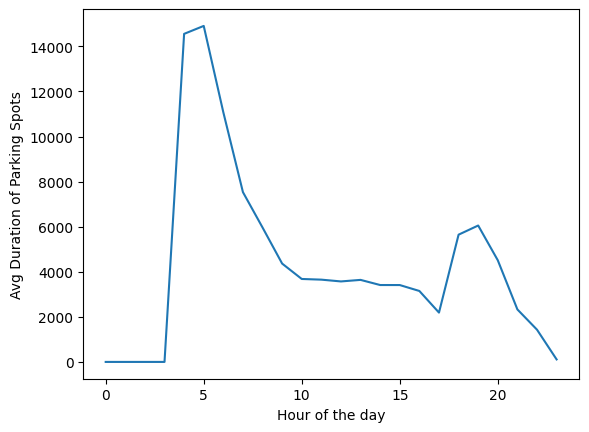

In [ ]:
hourly_counts = df.groupby(df['session_start_dt'].dt.hour)['duration'].mean()

# Create a line plot of the hourly counts
plt.plot(hourly_counts.index, hourly_counts.values)

# Set the x-axis label
plt.xlabel('Hour of the day')

# Set the y-axis label
plt.ylabel('Avg Duration of Parking Spots')

# Show the plot
plt.show()

In [ ]:
# Compute the correlation matrix
corr_matrix = df.corr()['duration']

print(corr_matrix.sort_values(ascending = False))

duration            1.000000
gross_paid_amt      0.685288
longitude           0.276115
latitude            0.192930
day_of_week         0.046715
meter_event_type    0.013378
hour               -0.166206
Name: duration, dtype: float64


#Models

##Classification
####Goal: Given a customer's desired wait time, will they find a parking spot at a given street?

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/INDENG 142 Final Project/final.csv')

In [ ]:
df_c = df.copy()
df_c = df_c[['gross_paid_amt','duration','meter_event_type', 'hour', 'day_of_week',
       'latitude', 'longitude', 'on_offstreet_type', 'meter_type']]

#####Wait Time: 10 Minutes

In [ ]:
# setting 600 seconds as the duration for getting parking to be 1
df_c['parking_yes'] = df_c['duration'].apply(lambda x: 1 if x <= 600 else 0)
#Getting dummy variables for meter_type and on_offstreet_type
df_c = pd.get_dummies(df_c, columns=['meter_type', 'on_offstreet_type'], drop_first=True)

In [ ]:
# Define the independent variables and target variable
y = df_c['parking_yes']
X = df_c[['hour', 'day_of_week','latitude', 'longitude', 'on_offstreet_type_ON', 'meter_type_SS']]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the training and testing sets
print('Training set:', X_train.shape, y_train.shape)
print('Testing set:', X_test.shape, y_test.shape)

Training set: (1493925, 6) (1493925,)
Testing set: (373482, 6) (373482,)


In [ ]:
#training logistic regression model
X_train = sm.add_constant(X_train)
model = sm.Logit(y_train, X_train).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.351587
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:            parking_yes   No. Observations:              1493925
Model:                          Logit   Df Residuals:                  1493918
Method:                           MLE   Df Model:                            6
Date:                Sun, 07 May 2023   Pseudo R-squ.:                 0.03466
Time:                        23:59:21   Log-Likelihood:            -5.2525e+05
converged:                       True   LL-Null:                   -5.4410e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 -847.0894     13.303    -63.676      0.000    -873.163    -821.01

Checking VIF

In [ ]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif["features"] = X_train.columns
print(vif)

     VIF Factor              features
0  3.078295e+07                 const
1  1.000501e+00                  hour
2  1.001984e+00           day_of_week
3  1.095084e+00              latitude
4  1.115599e+00             longitude
5  1.324364e+00  on_offstreet_type_ON
6  1.319811e+00         meter_type_SS


Since VIF < 10, our data is not multicollinear

In [ ]:
X_test = sm.add_constant(X_test)
# Make predictions
predictions = model.predict(X_test)
predictions_rounded = [round(x) for x in predictions]

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions_rounded)

# Print the accuracy
print('Accuracy:', accuracy)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, predictions_rounded)

# Print the confusion matrix
print(cm)

Accuracy: 0.880655560375065
[[328909      0]
 [ 44573      0]]


TN: 328909, FP: 0, FN: 44573, TP: 0, Precision: 0, Recall: 0, Specificity: 1

#####Wait Time: 30 Minutes

In [ ]:
df_c = df.copy()
df_c = df_c[['gross_paid_amt','duration','meter_event_type', 'hour', 'day_of_week',
       'latitude', 'longitude', 'on_offstreet_type', 'meter_type']]

# setting 1800 seconds as the duration for getting parking to be 1
df_c['parking_yes'] = df_c['duration'].apply(lambda x: 1 if x <= 1800 else 0)
#Getting dummy variables for meter_type and on_offstreet_type
df_c = pd.get_dummies(df_c, columns=['meter_type', 'on_offstreet_type'], drop_first=True)

In [ ]:
y = df_c['parking_yes']
X = df_c[['meter_event_type', 'hour', 'day_of_week',
       'latitude', 'longitude', 'on_offstreet_type_ON', 'meter_type_SS']]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the training and testing sets
print('Training set:', X_train.shape, y_train.shape)
print('Testing set:', X_test.shape, y_test.shape)

X_train = sm.add_constant(X_train)
model = sm.Logit(y_train, X_train).fit()
print(model.summary())

Training set: (1493925, 7) (1493925,)
Testing set: (373482, 7) (373482,)
Optimization terminated successfully.
         Current function value: 0.646233
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            parking_yes   No. Observations:              1493925
Model:                          Logit   Df Residuals:                  1493917
Method:                           MLE   Df Model:                            7
Date:                Sun, 07 May 2023   Pseudo R-squ.:                 0.05788
Time:                        23:59:54   Log-Likelihood:            -9.6542e+05
converged:                       True   LL-Null:                   -1.0247e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const          

In [ ]:
#Checking Accuracy and Confusion Matrix
X_test = sm.add_constant(X_test)
# Make predictions
predictions = model.predict(X_test)
predictions_rounded = [round(x) for x in predictions]

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions_rounded)

# Print the accuracy
print('Accuracy:', accuracy)

from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(y_test, predictions_rounded)

# Print the confusion matrix
print(cm)

Accuracy: 0.6298777451122143
[[161477  47423]
 [ 90811  73771]]


In [ ]:
print("Precision: " , 73771 / (73771 + 47423))
print("Recall: " , 73771 / (73771 + 90811))
print("Precision: " , 161477 / (161477 + 90811))

Precision:  0.6087017509117613
Recall:  0.4482324920100619
Precision:  0.6400502600202943


Seeing that at 30 minutes we get false positives and true positives(as opposed to none in the 10 minutes), we know that our data does not have enough true values for y at the sub 10 minute mark and is biased towards predicting negative. 
Let's aim to improve the model that tells us if we'd get parking if we're willing to wait 30 minutes by adding additional features.

In [ ]:
df_c = df.copy()
df_c = df_c[['gross_paid_amt','duration','meter_event_type', 'hour', 'day_of_week',
       'latitude', 'longitude', 'on_offstreet_type', 'meter_type']]

# setting 1800 seconds as the duration for getting parking to be 1
df_c['parking_yes'] = df_c['duration'].apply(lambda x: 1 if x <= 1800 else 0)
df_c = pd.get_dummies(df_c, columns=['meter_type', 'on_offstreet_type'], drop_first=True)


# Define the independent variables and target variable
y = df_c['parking_yes']
X = df_c[['gross_paid_amt', 'hour', 'day_of_week',
       'latitude', 'longitude', 'meter_type_SS']] #removing meter_event_type, and on_offstreet_type as statistically insignificant

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X_train = sm.add_constant(X_train)
model = sm.Logit(y_train, X_train).fit()
print(model.summary())

X_test = sm.add_constant(X_test)
# Make predictions
predictions = model.predict(X_test)
predictions_rounded = [round(x) for x in predictions]

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions_rounded)

# Print the accuracy
print('Accuracy:', accuracy)

from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(y_test, predictions_rounded)

# Print the confusion matrix
print(cm)

Optimization terminated successfully.
         Current function value: 0.379285
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:            parking_yes   No. Observations:              1493925
Model:                          Logit   Df Residuals:                  1493918
Method:                           MLE   Df Model:                            6
Date:                Mon, 08 May 2023   Pseudo R-squ.:                  0.4471
Time:                        00:00:14   Log-Likelihood:            -5.6662e+05
converged:                       True   LL-Null:                   -1.0247e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -1106.1380     12.410    -89.134      0.000   -1130.461   -1081.815
gross_paid_amt  

In [ ]:
print("Precision: " , 145043 / (145043 + 42542))
print("Recall: " , 145043 / (145043 + 19539))
print("Precision: " , 166358 / (166358 + 19539))

Precision:  0.7732121438281312
Recall:  0.8812810635427932
Precision:  0.8948934087155791


##Regression

In [ ]:
# calculate Variance Inflation Factor for each explanatory variable
from statsmodels.stats.outliers_influence import variance_inflation_factor

# The dataframe passed to VIF must include the intercept term. We add it the same way we did before.
def VIF(df, columns):
    values = sm.add_constant(df[columns]).values
    num_columns = len(columns)+1
    vif = [variance_inflation_factor(values, i) for i in range(num_columns)]
    return pd.Series(vif[1:], index=columns)



Model 1 with 5 features

In [ ]:
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor


# Define the formula for the linear regression model
formula = 'duration ~ gross_paid_amt + hour + day_of_week + latitude + longitude'

# Split the DataFrame into training and testing sets
train, test = train_test_split(df, test_size=0.2, random_state=88)

# Fit the linear regression model using the training data
model1 = smf.ols(formula=formula, data=train).fit()

# Use the model to make predictions on the test data
predictions = model1.predict(test)


# Compute and print the VIF values for the predictor variables
X = train[['gross_paid_amt', 'hour', 'day_of_week', 'latitude', 'longitude']]
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["Predictor"] = X.columns
print(vif)

print(model1.summary())

# Evaluate the performance of the model using a metric such as mean squared error
mse = ((test['duration'] - predictions) ** 2).mean()
print('Mean squared error:', mse)


     VIF Factor       Predictor
0  1.784110e+00  gross_paid_amt
1  2.308256e+01            hour
2  3.383989e+00     day_of_week
3  2.476620e+06        latitude
4  2.475506e+06       longitude
                            OLS Regression Results                            
Dep. Variable:               duration   R-squared:                       0.498
Model:                            OLS   Adj. R-squared:                  0.498
Method:                 Least Squares   F-statistic:                 2.969e+05
Date:                Mon, 08 May 2023   Prob (F-statistic):               0.00
Time:                        00:00:31   Log-Likelihood:            -1.3683e+07
No. Observations:             1493925   AIC:                         2.737e+07
Df Residuals:                 1493919   BIC:                         2.737e+07
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  

In [ ]:
# compute out-of-sample R-squared using the test set
def OSR2(model, df_train, df_test, dependent_var):   
    y_test = df_test[dependent_var]
    y_pred = model.predict(df_test)
    SSE = np.sum((y_test - y_pred)**2)
    SST = np.sum((y_test - np.mean(df_train[dependent_var]))**2)    
    return 1 - SSE/SST

In [ ]:
OSR2(model1, train, test, 'duration')

0.49900730606793575

Visualizations for model 1

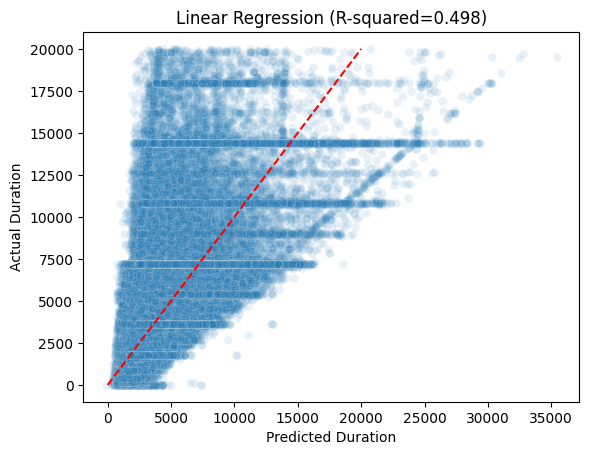

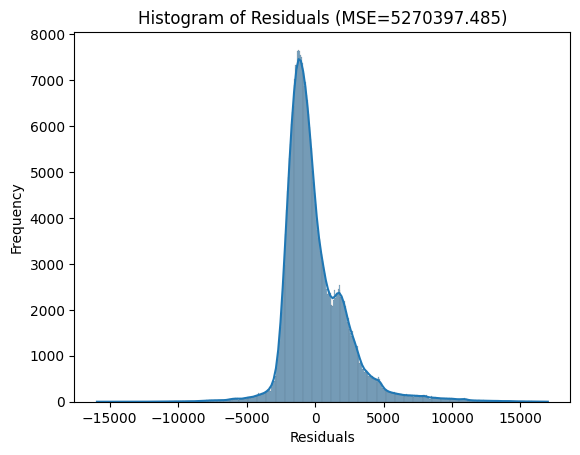

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Use the model to make predictions on the test data
predictions = model1.predict(test)

# Calculate the residuals (errors)
residuals = test['duration'] - predictions

# Create a scatter plot of the predicted vs actual values
sns.scatterplot(x=predictions, y=test['duration'], alpha=0.1)
plt.xlabel('Predicted Duration')
plt.ylabel('Actual Duration')

# Add a diagonal line to the plot to show perfect predictions
plt.plot([0, test['duration'].max()], [0, test['duration'].max()], color='red', linestyle='--')

# Set the plot title to display the R-squared value
plt.title(f"Linear Regression (R-squared={model1.rsquared:.3f})")

# Add a histogram of the residuals below the scatter plot
fig, ax = plt.subplots()
sns.histplot(residuals, kde=True, ax=ax)
ax.set_xlabel('Residuals')
ax.set_ylabel('Frequency')

# Set the histogram title to display the mean squared error
mse = ((test['duration'] - predictions) ** 2).mean()
ax.set_title(f"Histogram of Residuals (MSE={mse:.3f})")

# Show the plot
plt.show()


Model 2 with 4 features

In [ ]:
# Define the formula for the linear regression model
formula = 'duration ~ hour + day_of_week + latitude + longitude'

# Split the DataFrame into training and testing sets
train, test = train_test_split(df, test_size=0.2, random_state=88)

# Fit the linear regression model using the training data
model2 = smf.ols(formula=formula, data=train).fit()

# Use the model to make predictions on the test data
predictions = model2.predict(test)


# Compute and print the VIF values for the predictor variables
X = train[['gross_paid_amt', 'hour', 'day_of_week', 'latitude', 'longitude']]
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["Predictor"] = X.columns
print(vif)

print(model2.summary())

# Evaluate the performance of the model using a metric such as mean squared error
mse = ((test['duration'] - predictions) ** 2).mean()
print('Mean squared error:', mse)

     VIF Factor       Predictor
0  1.784110e+00  gross_paid_amt
1  2.308256e+01            hour
2  3.383989e+00     day_of_week
3  2.476620e+06        latitude
4  2.475506e+06       longitude
                            OLS Regression Results                            
Dep. Variable:               duration   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.119
Method:                 Least Squares   F-statistic:                 5.056e+04
Date:                Mon, 08 May 2023   Prob (F-statistic):               0.00
Time:                        00:01:04   Log-Likelihood:            -1.4103e+07
No. Observations:             1493925   AIC:                         2.821e+07
Df Residuals:                 1493920   BIC:                         2.821e+07
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  

In [ ]:
OSR2(model2, train, test, 'duration')

0.11902686441958688

Visualizations for model 2

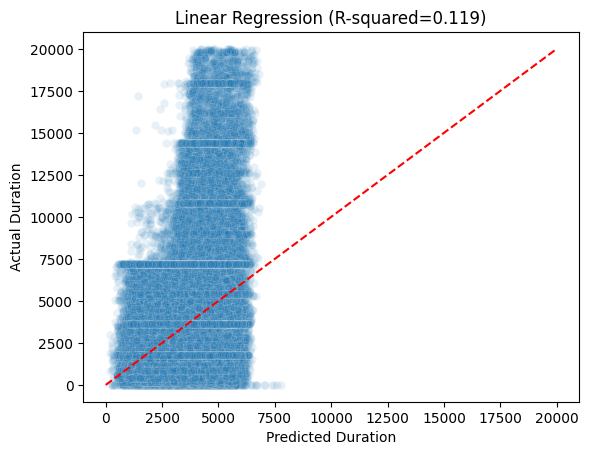

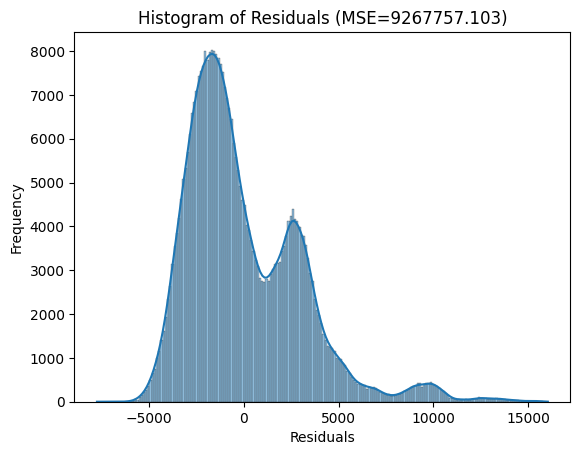

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Use the model to make predictions on the test data
predictions = model2.predict(test)

# Calculate the residuals (errors)
residuals = test['duration'] - predictions

# Create a scatter plot of the predicted vs actual values
sns.scatterplot(x=predictions, y=test['duration'], alpha=0.1)
plt.xlabel('Predicted Duration')
plt.ylabel('Actual Duration')

# Add a diagonal line to the plot to show perfect predictions
plt.plot([0, test['duration'].max()], [0, test['duration'].max()], color='red', linestyle='--')

# Set the plot title to display the R-squared value
plt.title(f"Linear Regression (R-squared={model2.rsquared:.3f})")

# Add a histogram of the residuals below the scatter plot
fig, ax = plt.subplots()
sns.histplot(residuals, kde=True, ax=ax)
ax.set_xlabel('Residuals')
ax.set_ylabel('Frequency')

# Set the histogram title to display the mean squared error
mse = ((test['duration'] - predictions) ** 2).mean()
ax.set_title(f"Histogram of Residuals (MSE={mse:.3f})")

# Show the plot
plt.show()


##KMeans Clustering

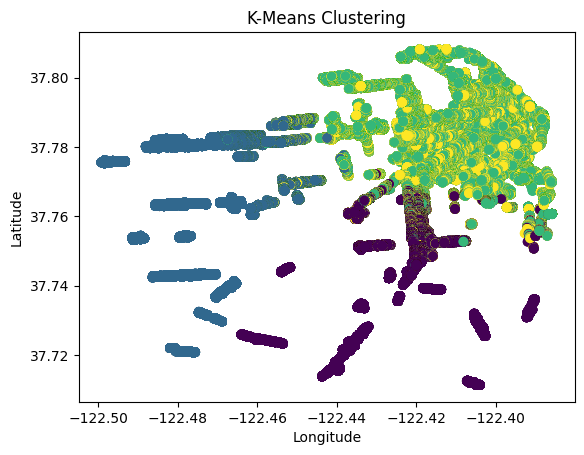

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pandas as pd

# Select the relevant columns
X = df[['latitude', 'longitude', 'day_of_week', 'hour', 'duration', 'gross_paid_amt']]

# Normalize the data
scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X)

# Determine the optimal number of clusters using the elbow method
#distortions = []
#for i in range(1, 11):
#    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=0)
#    km.fit(X_norm)
#    distortions.append(km.inertia_)
#plt.plot(range(1,11), distortions, marker='o')
#plt.xlabel('Number of clusters')
#plt.ylabel('Distortion')
#plt.show()

# Apply K-Means clustering with the optimal number of clusters
km = KMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=300, random_state=0)
y_km = km.fit_predict(X_norm)

# Visualize the clusters on a scatter plot
plt.scatter(X['longitude'], X['latitude'], c=y_km, cmap='viridis')
plt.title('K-Means Clustering')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [ ]:
df['cluster'] = y_km

In [ ]:
cluster_data = df[['cluster', 'day_of_week', 'hour', 'duration']]

# Group by cluster, day, and hour, and compute the mean duration
mean_duration = cluster_data.groupby(['cluster', 'day_of_week', 'hour'])['duration'].mean()

# Print the resulting mean duration values
print(mean_duration)

cluster  day_of_week  hour
0        0            3          0.000000
                      6       7767.750000
                      7       6288.000000
                      8       3212.413669
                      9       2038.058107
                                 ...     
3        2            19      6214.398749
                      20      4477.814496
                      21      2444.129187
                      22      1599.576923
                      23         0.000000
Name: duration, Length: 413, dtype: float64


In [ ]:
lat = 37.7749
lon = -122.48
day = 3
hour = 15
gross_paid_amt = 1.0

# Scale the input values and predict the cluster using the KMeans model
X_pred = scaler.transform([[lat, lon, day, hour, gross_paid_amt, 0]])
cluster_pred = km.predict(X_pred)[0]

# Get the mean duration of the predicted cluster for the specified day and hour
mean_duration_pred = round(mean_duration.loc[(cluster_pred, day, hour)] / 60)

# Print the predicted duration
print(mean_duration_pred, "minutes")

40 minutes


# Random Forest with KMeans

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[['hour', 'day_of_week', 'cluster', 'latitude', 'longitude', 'gross_paid_amt']], df['duration'], test_size=0.2, random_state=88)

# Train a random forest regression model
rf = RandomForestRegressor(n_estimators=100, random_state=88)
rf.fit(X_train, y_train)

# Evaluate the model on the testing set
y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean squared error: {mse}")

Mean squared error: 1385823.9706878322


In [ ]:
def OSR2(model, X_test, y_test, y_train):
  y_pred = model.predict(X_test)
  SSE = np.sum((y_test - y_pred)**2)
  SST = np.sum((y_test - np.mean(y_train))**2)
  return (1 - SSE/SST)

In [ ]:
print('OSR2:', round(OSR2(rf, X_test, y_test, y_train), 5))

OSR2: 0.86827


In [ ]:
# Calculate the VIF for each variable
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif["features"] = X_train.columns

print(vif)

     VIF Factor        features
0  2.310047e+01            hour
1  4.164184e+00     day_of_week
2  9.799799e+00         cluster
3  5.274932e+06        latitude
4  5.262063e+06       longitude
5  1.793762e+00  gross_paid_amt


In [ ]:
# Make a prediction for a new data point
new_data = pd.DataFrame({'hour': [11], 'day_of_week': [2], 'cluster': [0], 'latitude': [37.7749], 'longitude': [-122.4194], 'gross_paid_amt' : [0.5]})
prediction = rf.predict(new_data)
print('Predicted duration: {:.2f} minutes'.format(prediction[0]/60))

Predicted duration: 14.08 minutes
